In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from fancyimpute import IterativeSVD, SoftImpute
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_combined = pd.concat([X_train, X_test], axis=0)

In [4]:
# Initialize IterativeSVD for imputation
iterative_svd = IterativeSVD()

# Perform IterativeSVD Imputation on the combined dataset
X_combined_imputed_iterative = iterative_svd.fit_transform(X_combined)
X_train_imputed_iterative = X_combined_imputed_iterative[:len(X_train), :]
X_test_imputed_iterative = X_combined_imputed_iterative[len(X_train):, :]

softimpute = SoftImpute()
# Perform SoftImpute on the combined dataset
X_combined_imputed_soft = softimpute.fit_transform(X_combined)
X_train_imputed_soft = X_combined_imputed_soft[:len(X_train), :]
X_test_imputed_soft = X_combined_imputed_soft[len(X_train):, :]

[IterativeSVD] Iter 1: observed MAE=290.522514
[IterativeSVD] Iter 2: observed MAE=197.616056
[IterativeSVD] Iter 3: observed MAE=28.356853
[IterativeSVD] Iter 4: observed MAE=1.697254
[IterativeSVD] Iter 5: observed MAE=0.503289
[SoftImpute] Max Singular Value of X_init = 403977.444542
[SoftImpute] Iter 1: observed MAE=72.138084 rank=5
[SoftImpute] Iter 2: observed MAE=72.589102 rank=5
[SoftImpute] Iter 3: observed MAE=71.705811 rank=4
[SoftImpute] Iter 4: observed MAE=71.252901 rank=4
[SoftImpute] Iter 5: observed MAE=71.013974 rank=4
[SoftImpute] Iter 6: observed MAE=70.906418 rank=4
[SoftImpute] Iter 7: observed MAE=70.862595 rank=4
[SoftImpute] Iter 8: observed MAE=70.841562 rank=4
[SoftImpute] Iter 9: observed MAE=70.832763 rank=4
[SoftImpute] Iter 10: observed MAE=70.830568 rank=4
[SoftImpute] Iter 11: observed MAE=70.832055 rank=4
[SoftImpute] Iter 12: observed MAE=70.835160 rank=4
[SoftImpute] Iter 13: observed MAE=70.838895 rank=4
[SoftImpute] Iter 14: observed MAE=70.842834 

In [5]:
X_train_imputed_svd = pd.DataFrame(X_train_imputed_iterative, columns=X_train.columns)
X_test_imputed_svd = pd.DataFrame(X_test_imputed_iterative, columns=X_test.columns)

X_train_imputed_sm = pd.DataFrame(X_train_imputed_soft, columns=X_train.columns)
X_test_imputed_sm = pd.DataFrame(X_test_imputed_soft, columns=X_test.columns)

In [6]:
dataframes = [
    X_train_imputed_svd, X_test_imputed_svd, 
    X_train_imputed_sm, X_test_imputed_sm,
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


### Stratified Cross-Validation


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score, make_scorer
import numpy as np

def run_random_forest(classifier_name, imp_method, X_train, y_train):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        kf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
        )
        
        metrics = {"accuracy": make_scorer(accuracy_score),
                   "balanced_accuracy": make_scorer(balanced_accuracy_score),  
                   "precision": make_scorer(precision_score, average="weighted"), 
                   "recall": make_scorer(recall_score, average="weighted"), 
                   "f1_weighted": make_scorer(f1_score, average="weighted"),
                   "roc_auc_ovr_weighted": make_scorer(roc_auc_score, 
                                                       average="weighted", 
                                                       multi_class="ovr", 
                                                       response_method="predict_proba",),
        }
        
        cross_val_results = cross_validate(rf,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring=metrics,
                                           return_train_score=True,
        )
                
        metric_names = list(metrics.keys())
        mean_train = [round(np.mean(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        std_train = [round(np.std(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        mean_test = [round(np.mean(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        std_test = [round(np.std(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        time = round(np.mean(cross_val_results[f"fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Fit Time": time,
                "Metric": metric_names,
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = rf.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [8]:
svd_model, svd_metrics = run_random_forest("Random Forest", "IterSVD", X_train_imputed_svd, y_train)
soft_model, soft_metrics = run_random_forest("Random Forest", "SoftImpute", X_train_imputed_soft, y_train)

In [9]:
validation_df = pd.concat([svd_metrics, soft_metrics])
validation_df_report = validation_df.set_index(["Classifier", "Imputation", "Fit Time", "Metric"])
validation_df_report

Mean Train  Std Train  \
Classifier    Imputation Fit Time Metric                                        
Random Forest IterSVD    0.500    accuracy                   0.907      0.010   
                                  balanced_accuracy          0.914      0.008   
                                  precision                  0.911      0.008   
                                  recall                     0.907      0.010   
                                  f1_weighted                0.905      0.010   
                                  roc_auc_ovr_weighted       0.986      0.002   
              SoftImpute 0.635    accuracy                   0.906      0.009   
                                  balanced_accuracy          0.912      0.011   
                                  precision                  0.911      0.008   
                                  recall                     0.906      0.009   
                                  f1_weighted                0.905      0.009   
                                  roc_auc_ovr_weighted       0.985      0.002   

                                                        Mean Test  Std Test  
Classifier    Imputation Fit Time Metric                                     
Random Forest IterSVD    0.500    accuracy                  0.638     0.020  
                                  balanced_accuracy         0.565     0.018  
                                  precision                 0.621     0.008  
                                  recall                    0.638     0.020  
                                  f1_weighted               0.617     0.015  
                                  roc_auc_ovr_weighted      0.831     0.028  
              SoftImpute 0.635    accuracy                  0.621     0.029  
                                  balanced_accuracy         0.555     0.021  
                                  precision                 0.603     0.035  
                                  recall                    0.621     0.029  
                                  f1_weighted               0.602     0.031  
                                  roc_auc_ovr_weighted      0.830     0.018

C:\Users\steve\AppData\Local\Temp\ipykernel_17416\3338831822.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


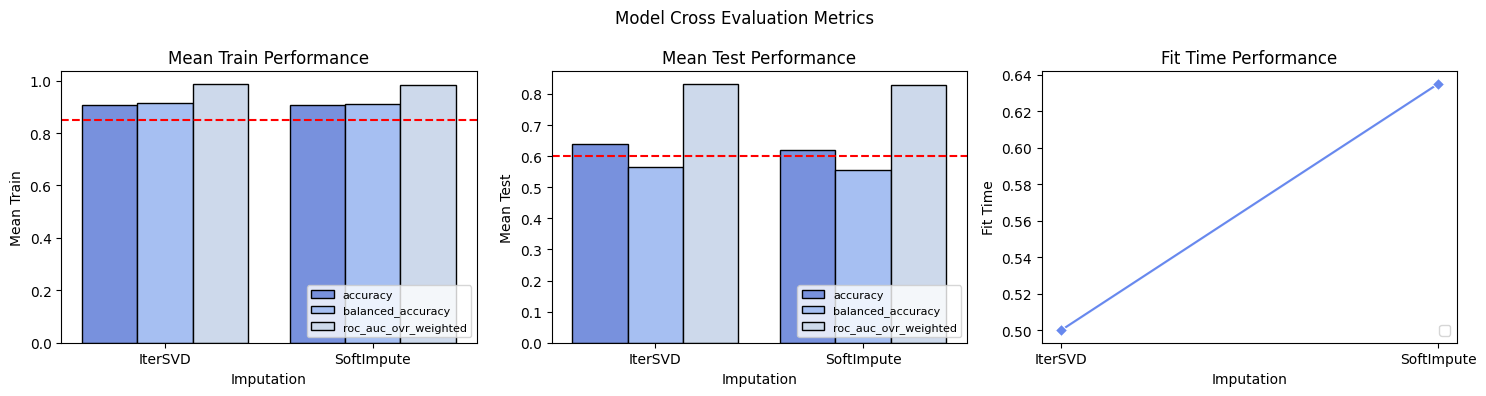

In [12]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_validation = validation_df[validation_df['Metric'].isin(metrics_to_plot)]
filtered_df_validation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Evaluation Metrics")
sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Train', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower right",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Mean Train Performance")

sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Test', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower right",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Mean Test Performance")

sns.lineplot(data=filtered_df_validation, x='Imputation', y=filtered_df_validation['Fit Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()

### Evaluate

In [10]:
import time

def eval_random_forest(classifier_name, imp_method, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Classification Time": round(elapsed_time, 3),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [13]:
pred_svd = eval_random_forest("Random Forest", "IterSVD", svd_model, X_train_imputed_svd, X_test_imputed_svd, y_train, y_test)
pred_soft = eval_random_forest("Random Forest", "SoftImpute", soft_model, X_train_imputed_soft, X_test_imputed_soft, y_train, y_test)

In [14]:
prediction_df = pd.concat([pred_svd, pred_soft])
prediction_df_report = prediction_df.set_index(["Classifier", "Imputation",	"Classification Time", "Metric"])
prediction_df_report

Train data  \
Classifier    Imputation Classification Time Metric                             
Random Forest IterSVD    0.341               accuracy                   0.878   
                                             balanced_accuracy          0.886   
                                             precision                  0.882   
                                             recall                     0.878   
                                             f1_weighted                0.875   
                                             roc_auc_ovr_weighted       0.979   
              SoftImpute 0.195               accuracy                   0.889   
                                             balanced_accuracy          0.897   
                                             precision                  0.894   
                                             recall                     0.889   
                                             f1_weighted                0.887   
                                             roc_auc_ovr_weighted       0.981   

                                                                   Test data  
Classifier    Imputation Classification Time Metric                           
Random Forest IterSVD    0.341               accuracy                  0.557  
                                             balanced_accuracy         0.568  
                                             precision                 0.549  
                                             recall                    0.557  
                                             f1_weighted               0.543  
                                             roc_auc_ovr_weighted      0.810  
              SoftImpute 0.195               accuracy                  0.546  
                                             balanced_accuracy         0.560  
                                             precision                 0.534  
                                             recall                    0.546  
                                             f1_weighted               0.531  
                                             roc_auc_ovr_weighted      0.818

C:\Users\steve\AppData\Local\Temp\ipykernel_17416\3175058364.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


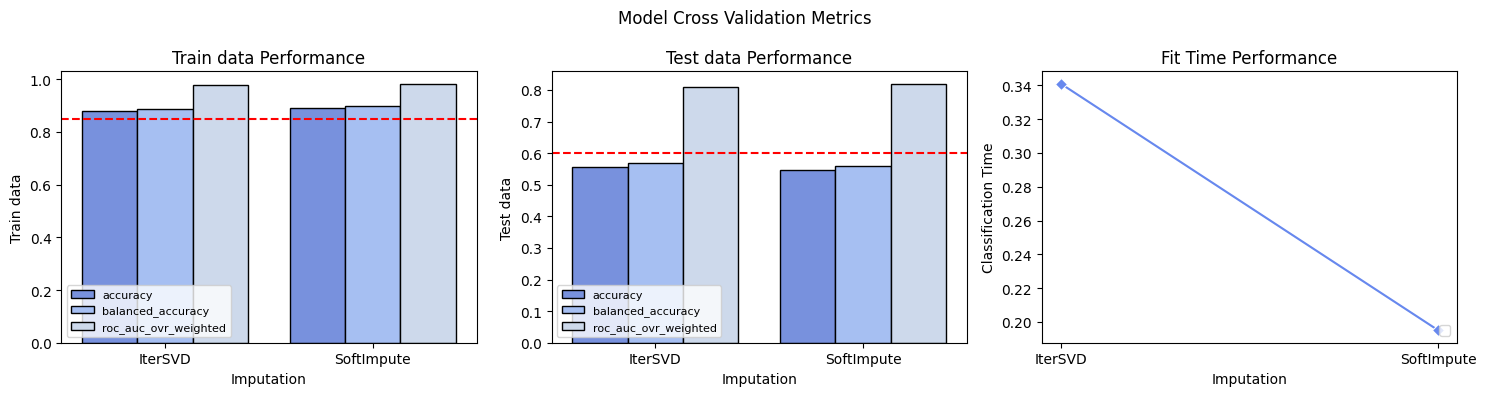

In [15]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_evaluation = prediction_df[prediction_df['Metric'].isin(metrics_to_plot)]
filtered_df_evaluation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Validation Metrics")
sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Train data', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower left",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Train data Performance")

sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Test data', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower left",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Test data Performance")

sns.lineplot(data=filtered_df_evaluation, x='Imputation', y=filtered_df_evaluation['Classification Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()